# Shor's algorithm for pulsar detection

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
from utils import generate_fake_data_2

## Generating ideal pulsar data

We first generate here ideal pulsar signal using the code in `generate_toy_pulsar_data`. 

In [2]:
# number of channels and time step of the signal
nchan, ntime = 64, 64

# real period of the pulsar (in time step)
period_real = 4

# the dispertion measure
dm_real = 20

# the amount of noise
noise_frac = 0.0

# generate the data
data = generate_fake_data_2(nchan, ntime, period_real, dm_real, noise_frac)

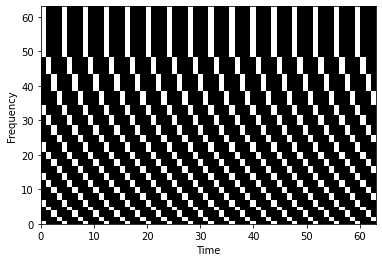

In [3]:
fig, ax = plt.subplots()
ax.imshow(data, vmin=0, vmax=1, origin='lower', aspect='auto',
          cmap='gray', extent=[0, ntime-1, 0, nchan-1])
ax.set_xlabel('Time')
ax.set_ylabel('Frequency')
fig.savefig("raw-data.svg")

As we see in the picture, each channel (i.e. each row of the image) contains a periodic peak over a constant background. Each channel is displaced horizontally from the previous one due to dispertion.

## Algorithm for period finding 

The period finding algorithm is very simple and contains only 5 steps described below. The algorithm is aimed at computing the period of a function $f(x)$. The algorithm uses two quantum registers that are initially in the state 

$$
|0\rangle|0\rangle
$$

The function is accessed as a Oracle that performs the following operation:

$$
f(|a\rangle|0\rangle) \rightarrow |a\rangle|f(a)\rangle
$$


1 - The first step consists in creating a full superposition on the first quantum register. This is usually done using Haddamard gates on all qbits of the register. The corresponding transformation reads :

$$
|0\rangle|0\rangle \rightarrow \sum_x |x\rangle|0\rangle 
$$

2 - Using the superposition on the first register we can compute all values of  $f$ in parallel : 

$$
\sum_x |x\rangle|0\rangle  \rightarrow \sum_x |x\rangle|f(x)\rangle 
$$

To give a concrete example, let's assume that the period of $f$ is 5 and that $f$ takes the values : $f(0) = a$, $f(1) = b$, $f(2) = c$ $f(3)=d$, $f(4)=e$, $f(5)=a$, $f(6)=b$ ... the state of the quantum system will then be:  

$$
|0\rangle|a\rangle + |1\rangle|b\rangle + |2\rangle|c\rangle + |3\rangle|d\rangle + |4\rangle|e\rangle + |5\rangle|a\rangle + |6\rangle|b\rangle + ...
$$

3 - The next step consist in measuring the 2nd register. Let's assume here that we measure $|b\rangle$, this measurement collapses the wave function to the state :

$$
( |1\rangle + |6\rangle + |12\rangle + |18\rangle + ... ) |b\rangle
$$

We see now that the perdiodicity of $f$ is reflected in the superposition of the first register.

4 - To extract the value of the periodicity, we apply an inverse QFT on the first register. Since this register is now on a periodic superposition, the result of the inverse Fourier transform will give the value of the frequency.

## Issue with the Shor's algorithm

We clearly see that the function $f$ must be injective within its period for the Shor's algorithm to work. This means that within a perdiod the function must take values like :

$$
f(0) = a \quad f(1) = b \quad f(2) = c \quad f(3)=d \quad f(4)=e
$$

but the algorithm will fail if the function takes the values :

$$
g(0) = a \quad g(1) = b \quad g(2) = c \quad g(3)=a \quad g(4)=c
$$

To see why the algorithm will fail let's consider the state of the circuit after step 2 with the function $g$ :

$$
|0\rangle|a\rangle + |1\rangle|b\rangle + |2\rangle|c\rangle + |3\rangle|a\rangle + |4\rangle|c\rangle + |5\rangle|a\rangle + |6\rangle|b\rangle + ...
$$

Let's now assume that during step 3 we measure $|a\rangle$ on the second register, this will collapse the wave function  to :

$$
( |0\rangle + |3\rangle + |5\rangle + |8\rangle + |10\rangle... ) |a\rangle
$$

We clearly see here that the superposition obtained of the first register does not present the correct periodicity. Before we use Shor's algorithm, we must therefore process the signal obtained from the pulsar so that it becomes injective during its period.

## Making injective signals

To make our pulsar signal injective we can consider several channels at once. As seen earlier the dispertion leads to a consistent shift of the signal that we can use to our advantage. There are of course many different channel conbination we can consider. For example let's say that we consider the 4 firsts channels. Let's assume that at a given time step these channels take the individual values :

$$
c_0 = 0 \quad c_1 = 1 \quad c_2 = 0 \quad c_3 = 1
$$

these individual channels will be concatenated in the 4 bit binary word :

$$
0101
$$

which can be converted to $0101=5$. Doing this for all time steps leads to signal that can if we are lucky be injective.


The function `integrate_signal` compute that automatically. In that function we simply consider that we take `n_count` channels, starting at index `start_index` and that we consider every other `increment` channels. The signal returned by that function can then be encoded in register containing `n_count` qubits.

[2, 0, 4, 9, 2, 0, 4, 9, 2, 0, 4, 9, 2, 0, 4, 9, 2, 0, 4, 9, 2, 0, 4, 9, 2, 0, 4, 9, 2, 0, 4, 9, 2, 0, 4, 9, 2, 0, 4, 9, 2, 0, 4, 9, 2, 0, 4, 9, 2, 0, 4, 9, 2, 0, 4, 9, 2, 0, 4, 9, 2, 0, 4, 9]


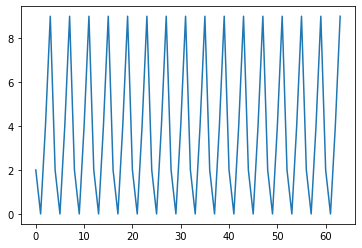

In [9]:
from utils import integrate_signal

n_count, start_index, increment = 4, 1, 2 
bits = integrate_signal(data, n_count, start_index, increment)

plt.plot(bits)
print(bits)

## Creating the Oracle function for the signal

Shor's algorithm uses the function $f$ as a oracle that performs the operation :

$$
f(|x\rangle|0\rangle) \rightarrow |x\rangle|f(x)\rangle
$$

We thereore need to create a Oracle that performs such operation. The Oracle operates on two registers. The first register encodes the values of the time step and should therefore contain `log2(ntime)` qubit. The first time step $t=0$ will be enoded in the register state $|00..0\rangle$ the second time stepm $t=1$ in $|00..1\rangle$ etc ... The second register will encode the value of the _injective_ pulsar signal generated by the integration of the raw data over several channels. This second register should therefore contains `n_cout` qubits.

The creation of the Oracle is then a simple $M$ matrix that transforms the initial state $|x0\rangle$ to : $|xf(x)\rangle$. 

In [10]:
# from qiskit.quantum_info.operators import Operator
from utils import tobin 
from qiskit.quantum_info.operators import Operator
def BooleanBitsOracle(bit, nbit):
    
    npts = data.shape[0]
    nqbits_register1 = int(np.log2(npts))
    
    nqbits_register2 = nbit
    size = 2**(nqbits_register1+nqbits_register2)
    
    M = np.eye(size,size)
    
    
    for x in range(npts):
        
        xbin = tobin(x, nqbits_register1)
        y = int(bit[x])
        ybin = tobin(y, nqbits_register2)

        if ybin !=0:
            
            idx = int(ybin+xbin, 2)
            M[int(xbin, 2), int(xbin, 2)] = 0
            M[idx, idx] = 0
            M[int(xbin, 2),idx] = 1
            M[idx, int(xbin, 2)] = 1
    
    op = Operator(M)
    op.label = 'oracle'
    return op
    
oracle = BooleanBitsOracle(bits, n_count)

## Creating the quantum circuit

As explained in introduction the circuit for Shor's algorithm contains 4 main parts :

        . The creation of a superposition through Hadammard gates
        . The call to the Oracle
        . The inverse QFT
        . The measurment 

These 4 steps are implemented below to create the full circuit. The circuit contains 2 quantum registers and 1 classical register to be able to read the output.

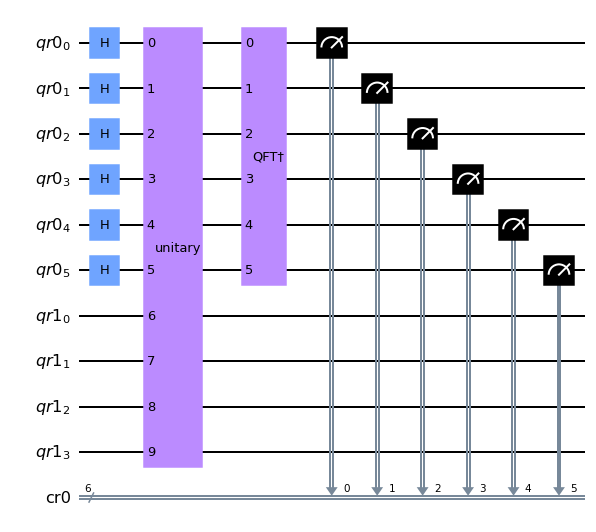

In [11]:
# Create QuantumCircuit with n_count counting qubits
# plus 4 qubits for U to act on
from utils import qft_dagger
nqubit_register1 = 6
nqubit_register2 = n_count

# initialize the quantum circuit
qc = QuantumCircuit(QuantumRegister(nqubit_register1, 'qr0'), 
                    QuantumRegister(nqubit_register2,'qr1'),
                    ClassicalRegister(nqubit_register1,'cr0'))


# Initialize counting qubits
# in state |+>
for q in range(nqubit_register1):
    qc.h(q)

# introduce the oracle
qc.append(oracle,list(range(0,nqubit_register1+nqubit_register2)))

# inverse QFT
qc.append(qft_dagger(nqubit_register1), range(nqubit_register1))

# Measure the first register
qc.measure(range(nqubit_register1),range(nqubit_register1))

# draw the circuit
qc.draw('mpl')  # -1 means 'do not fold' 

## Run the simulation

Now that everything is in place we can run the simulations. We use the Aer backend, run a bunch of simulations to gather statistic and plot an histogram of the results

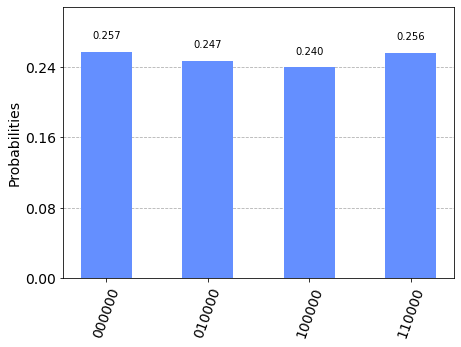

In [12]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)


## Analysis

The output of the circuit gives several binary words with different probablities. We can further analyse this output with the following snippet.

In [16]:
rows, measured_phases, measured_prob = [], [], []
norm = 0
for _, proba in counts.items():
    norm += proba
    
for output, proba in counts.items():
    norm_prob = proba/norm
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**nqubit_register1)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    measured_prob.append(norm_prob)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**nqubit_register1} = {phase:.2f}",
                norm_prob, phase])
# Print the rows in a table
headers=["Register Output", "Phase","Probability","NumPhase"]
df = pd.DataFrame(rows, columns=headers)
df.sort_values(by='Probability', inplace=True, ascending=False)
print(df)


          Register Output         Phase  Probability  NumPhase
0  000000(bin) =   0(dec)   0/64 = 0.00     0.256836      0.00
1  110000(bin) =  48(dec)  48/64 = 0.75     0.255859      0.75
2  010000(bin) =  16(dec)  16/64 = 0.25     0.247070      0.25
3  100000(bin) =  32(dec)  32/64 = 0.50     0.240234      0.50


The register output is first converted in decimal value which leads to the phase of the corresponding output value. This phase is used as input for a continuous fraction algorithm to extract the periodicity. This is done below

In [17]:
rows = []
for index, row in df.iterrows():
    frac = Fraction(row['NumPhase']).limit_denominator(20)
    rows.append([row['NumPhase'], f"{frac.numerator}/{frac.denominator}", frac.denominator, row['Probability']])
# Print as a table
headers=["Phase", "Fraction", "Guess for r", "Probability"]
df2 = pd.DataFrame(rows, columns=headers)
print(df2)
    

   Phase Fraction  Guess for r  Probability
0   0.00      0/1            1     0.256836
1   0.75      3/4            4     0.255859
2   0.25      1/4            4     0.247070
3   0.50      1/2            2     0.240234
